<a href="https://colab.research.google.com/github/ljs2021/Machine-Learning-Book-/blob/master/8%EC%A3%BC%EC%B0%A8(Stacking)_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stacking Ensemble

스태킹은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 앞에 소개한 Bagging Boosting 과 공통점을 자기고 있습니다. 

가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다. > 사이킷런 패키지가 제공되지 않아 사용자가 직접 코딩 해줘야함.

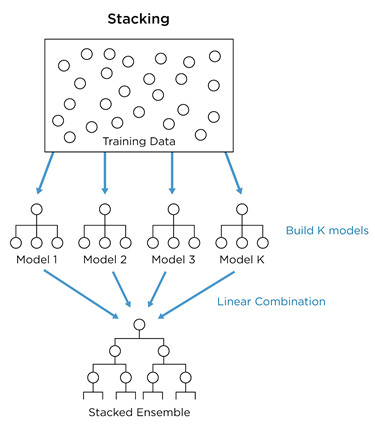

### **기본 스태킹 모델 ** 

In [1]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train,X_test,y_train,y_test = train_test_split(X_data,y_label,test_size=0.2,random_state=777)

In [2]:
#개별 모델 만든다.

knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습 , 예측할 최종 모델 
lr_final = LogisticRegression(C=10)  #C : regularization의 강도를 나타내는 parameter  C value가 낮을 수록 계수가 0으로 근사 regularization 강화

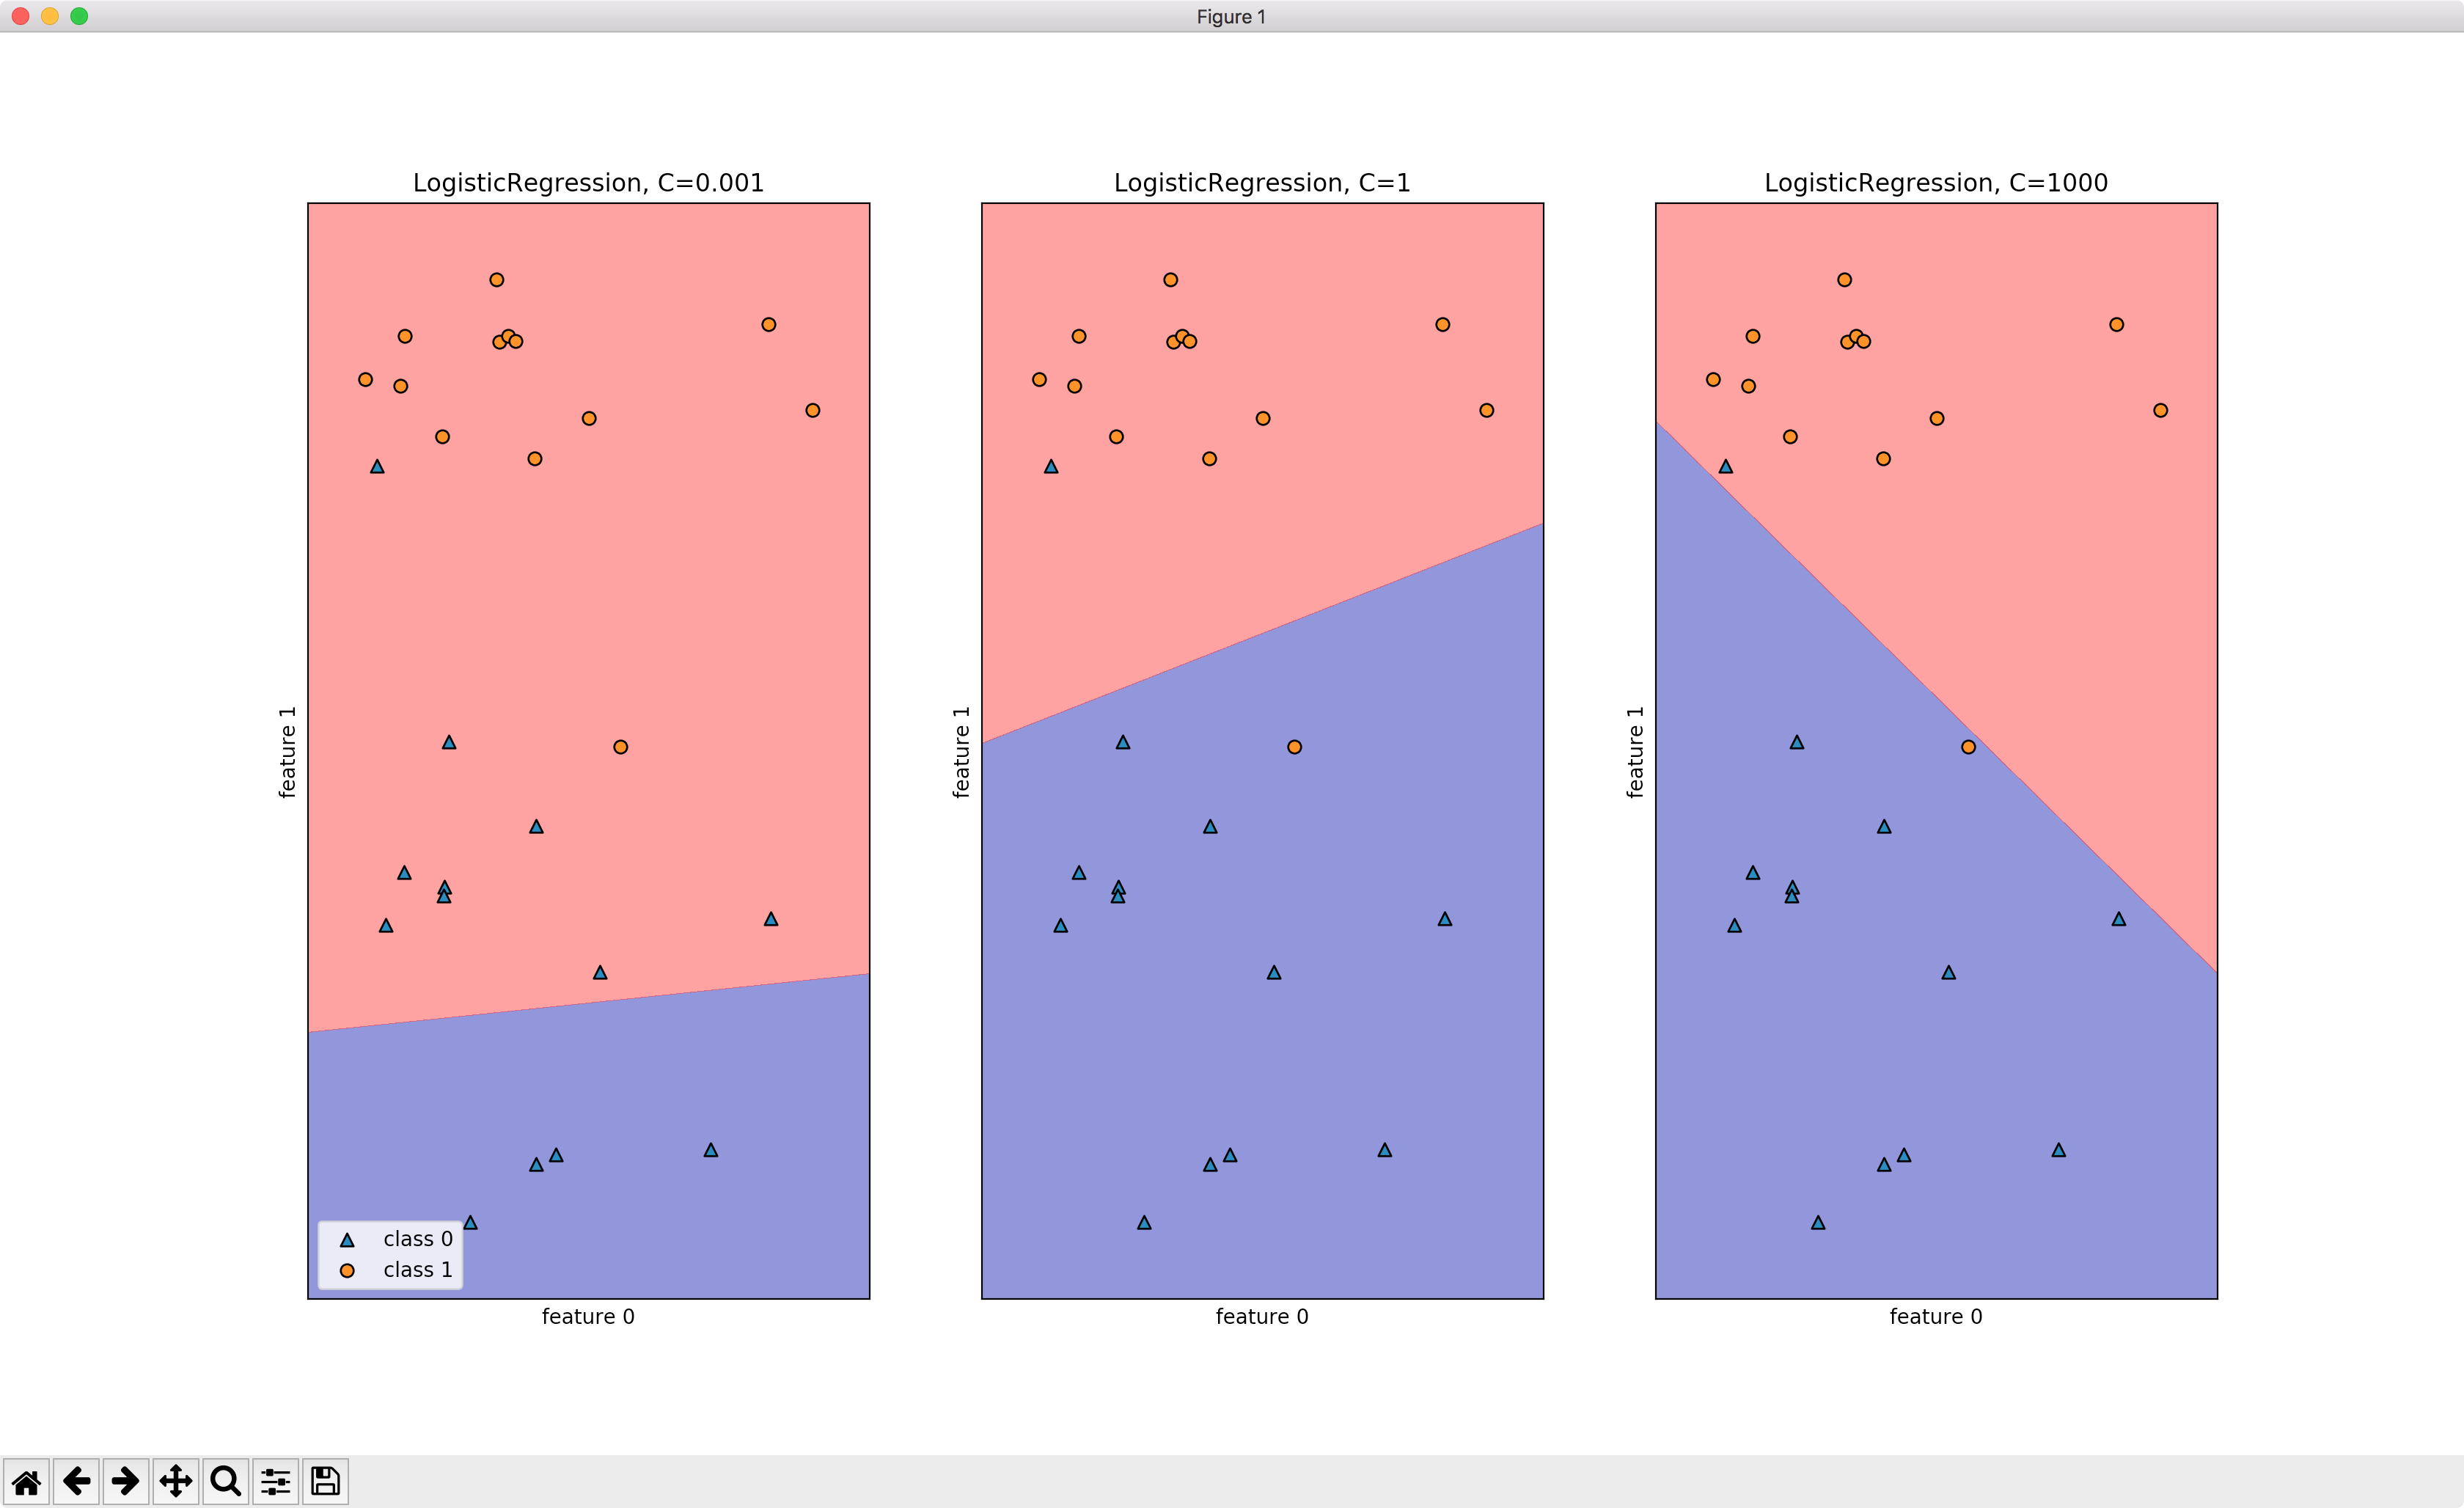

In [3]:
#개별 모델 학습 
knn_clf.fit(X_train,y_train)

rf_clf.fit(X_train,y_train)

dt_clf.fit(X_train,y_train)

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [4]:

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9561
랜덤 포레스트 정확도: 0.9561
결정 트리 정확도: 0.8947
에이다부스트 정확도: 0.9474 :


개별 알고리즘으로부터 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용 

반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 변환된 예측 결과를 행 형태로 붙인 뒤,numpy의 transpose()를 이용해 행과 열 위치를 바꾼 ndarray로 변환하면 됩니다. 


In [5]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [6]:
lr_final.fit(pred,y_test)
fianl = lr_final.predict(pred)

print("최종 메타 모델의 예측 정확도: {:.4f}".format(accuracy_score(y_test,fianl)))

최종 메타 모델의 예측 정확도: 0.9737


## CV 세트 기반의 스태킹 

CV 세트 기반의 스태닝 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용한다.

> step1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성 .

> step2 : step1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습할 최종 학습용 데이터 세트 생성. 똑같이 테스트용 데이터 생성. 이 데이터를 기반으로 예측.


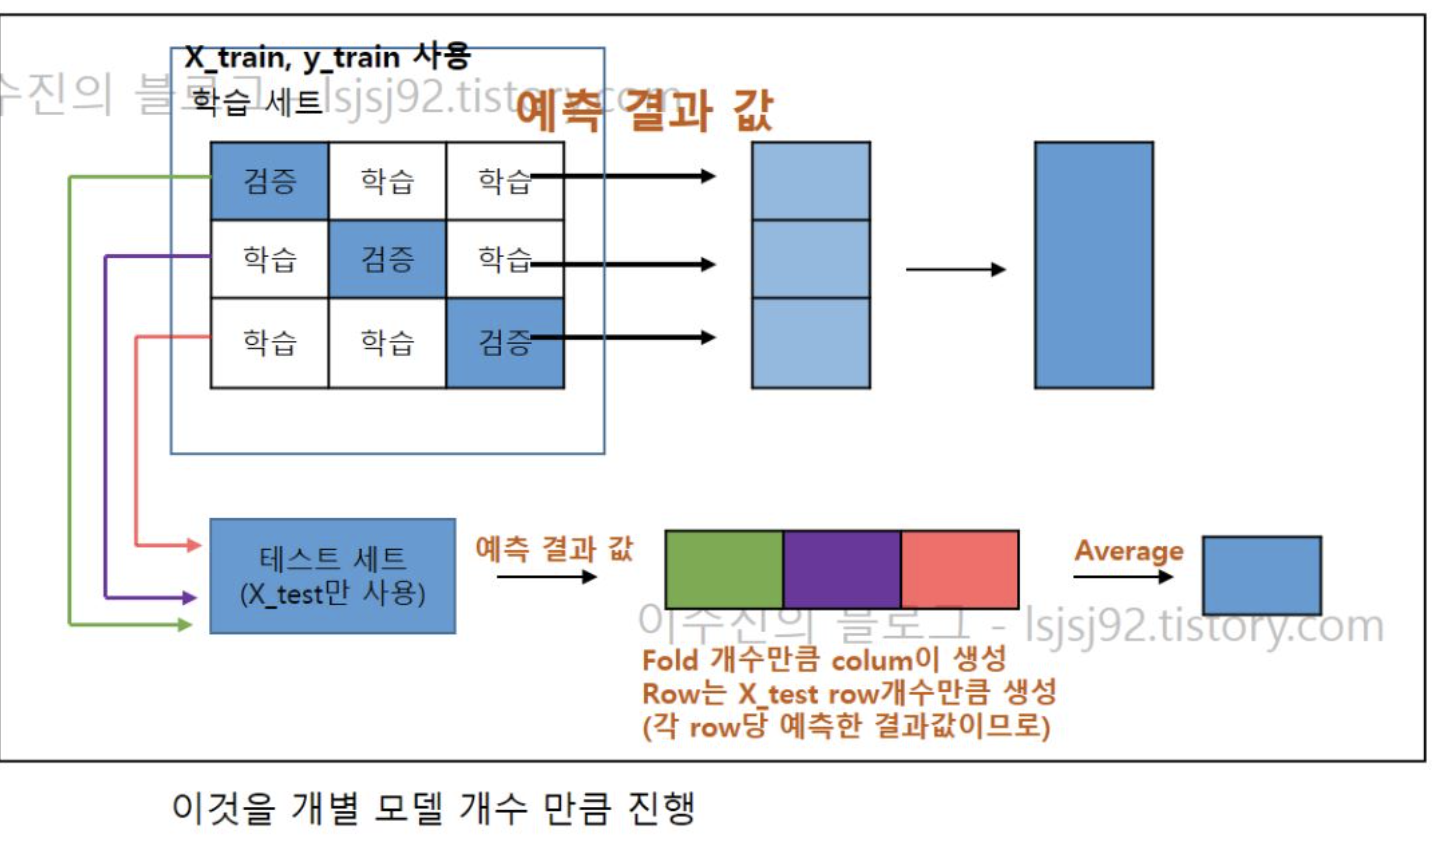

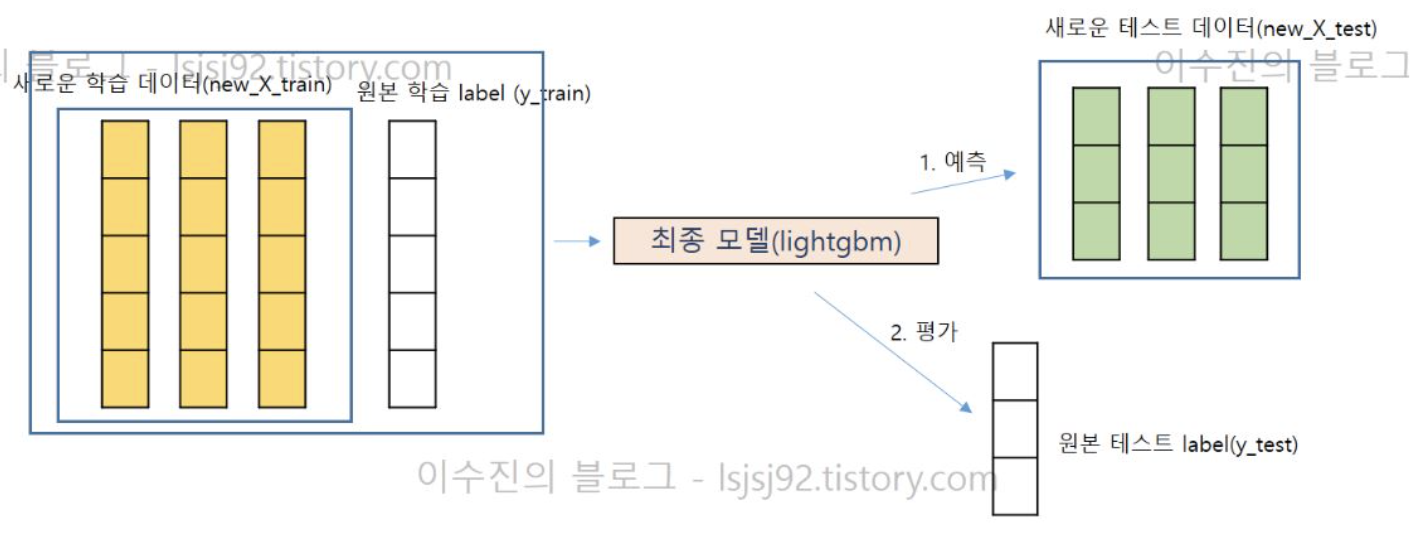

Step 1 코드 구현 

> 개별 모델이 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성.

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [16]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


Step2 : get_stacking_base_datasets() 호출로 반환된 각 모델별 학습 데이터와 테스트 데이터를 합치기만 하면 됩니다. 넢아이의 concatenate()를 이용해 쉽게 이와 같은 기능을 수행.

In [19]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

#스태킹 학습 피처 데이터는 원본 학습 피처 데이터와 row크기가 같으며, 4개의 개별 모델 예측값을 합친 것이므로 column은 4이다.

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후에 예측하고

예측한 결과를 원본 테스트 레이블 데이터와 비교해 정확도를 측정.

In [20]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print("최종 메타 모델의 예측 정확도 :{:.4}".format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도 :0.9737


## 정리 

대부분의 앙상블 기법은 결정 트리 기반의 다수의 약한 학습기(Weak Learner)를 결합해 변동성을 줄여 예측 오류를 줄이고 성능을 개선하고 있다. 

> DecisionTree 알고리즘은 정보의 균일도에 기반한 규칙 트리를 만들어 예측 수행. 다른 알고리즘에 비해 비교적 직관적이어서 어떻게 예측 결과가 도출되었는지 그 과정을 쉽게 알 수 있다.

> 단점: 균일한 최종 예측결과를 도출하기 위해 결정트리가 깊어지고 복잡해 지면서 과적합이 쉽게 발생 



앙상블 기법은 대표적으로 배깅과 부스팅으로 구분 , 배깅 방식은 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측 ( 대표적으로 RandomForest)

현대의 앙상블 기법은 배깅보다 부스팅이 더 주류 

 > 부스팅은 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해 보다 높은 정확도로 예측 가능.

 > 스태킹은 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재 생성하는 기법.